In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import gmean, gstd

In [2]:
kin_df = pd.read_excel('../data/enzymes/BarEven2011.xls', sheet_name='1. KineticTable')
modules_df = pd.read_excel('../data/enzymes/BarEven2011.xls', sheet_name='6. Metabolic Modules').set_index('Reaction ID (KEGG)')
module_groups_df = pd.read_excel('../data/enzymes/BarEven2011.xls', sheet_name='module_groups')


In [3]:
# Mark the kinetic data by where it lives in heterotrophic central metabolism
# Taxonomy here assigned by Bar-Even using the KEGG classification.
is_central = []
carb_energy = []
biosyn = []
central_types = set(['Primary - Carbohydrate & Energy Metabolism',
       'Primary - amino acids, fatty acids and nucleotides'])
carb_type = 'Primary - Carbohydrate & Energy Metabolism'
biosyn_type = 'Primary - amino acids, fatty acids and nucleotides'
for row_id, row in kin_df.iterrows():
    reaction_id = row['Reaction ID (KEGG)']
    central = False
    central_carb = False
    central_biosyn = False
    if reaction_id in modules_df.index:
        mods = modules_df.loc[reaction_id]['Module ID (KEGG)']
        if np.isscalar(mods):
            mods = [mods]
        mask = module_groups_df.ID.isin(list(mods))
        mods4reaction = set(module_groups_df[mask].Type.unique())
        if mods4reaction.intersection(central_types):
            central = True
        if carb_type in mods4reaction:
            central_carb = True
        if biosyn_type in mods4reaction:
            central_biosyn = True
    is_central.append(central)
    carb_energy.append(central_carb)
    biosyn.append(central_biosyn)
kin_df['is_central'] = is_central
kin_df['is_central_carbon_energy'] = carb_energy
kin_df['is_central_biosynthesis'] = biosyn
kin_df.head()

,EC1,EC2,EC3,EC4,Compound Id (KEGG),Reaction ID (KEGG),Reaction direction (KEGG),Organism ID,Publication ID,Temperature,pH,KM (µM),kcat (1/sec),is_central,is_central_carbon_energy,is_central_biosynthesis
0,1,1,1,1,84,754,1,7,2819000,NaN,NaN,3400.0,NaN,False,False,False
1,1,1,1,1,84,754,1,7,6395900,NaN,NaN,85.0,NaN,False,False,False
2,1,1,1,1,84,754,1,8,6354100,NaN,NaN,217.0,NaN,False,False,False
3,1,1,1,1,84,754,1,9,3282500,NaN,NaN,2830.0,NaN,False,False,False
4,1,1,1,1,84,754,1,12,3156600,NaN,NaN,53.0,NaN,False,False,False


Examining kcat (1/sec) values
	all central metabolism
		Median 23.0
		Geometric mean 20.35 +/- 18.42 fold

	central carbon and energy
		Median 41.3
		Geometric mean 51.30 +/- 13.85 fold

	central biosynthesis
		Median 13.0
		Geometric mean 11.70 +/- 18.80 fold

Examining KM (µM) values
	all central metabolism
		Median 160.0
		Geometric mean 169.86 +/- 12.68 fold

	central carbon and energy
		Median 120.0
		Geometric mean 152.00 +/- 10.97 fold

	central biosynthesis
		Median 200.0
		Geometric mean 191.62 +/- 13.84 fold



/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_65478/647756512.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_value = my_df[mask][col].median()
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_65478/647756512.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gmean_value = gmean(my_df[mask][col])
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_65478/647756512.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gstd_value = gstd(my_df[mask][col])
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_65478/647756512.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_value = my_df[mask][col].median()
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_65478/647756512.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gmean_value = gmean(my_df[mask][col])
/var/f

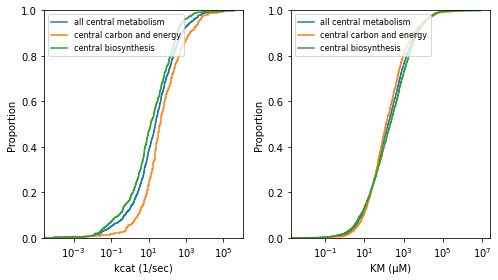

In [4]:
# Calculate summary statistics (geometric, multiplicative) of
# kinetic parameters by metabolic position.
central_carb_kin_df = kin_df[kin_df.is_central_carbon_energy]
central_biosyn_kin_df = kin_df[kin_df.is_central_biosynthesis]
central_kin_df = kin_df[kin_df.is_central]
central_dfs = [central_kin_df, central_carb_kin_df, central_biosyn_kin_df]
df_labels = ['all central metabolism', 'central carbon and energy', 'central biosynthesis']

fig, axs = plt.subplots(ncols=2, figsize=(7, 4))
pal = sns.color_palette()

kin_ranges = dict(label=[], param=[], gmean=[], gstd=[], median=[])
cols = 'kcat (1/sec),KM (µM)'.split(',')
for i, col in enumerate(cols):
    print('Examining', col, 'values')
    plt.sca(axs[i])
    for j, (label, my_df) in enumerate(zip(df_labels, central_dfs)):
        print('\t{0}'.format(label))
        
        mask = np.logical_and(
            central_kin_df[col] > 0,
            central_kin_df[col].notnull())

        median_value = my_df[mask][col].median()
        gmean_value = gmean(my_df[mask][col]) 
        gstd_value = gstd(my_df[mask][col])
        
        kin_ranges['label'].append(label)
        kin_ranges['param'].append(col)
        kin_ranges['gstd'].append(gstd_value)
        kin_ranges['gmean'].append(gmean_value)
        kin_ranges['median'].append(median_value)
        
        plt.xscale('log')
        sns.ecdfplot(data=my_df, x=col, color=pal[j], label=label)
        print('\t\tMedian', median_value)
        print('\t\tGeometric mean {0:.2f} +/- {1:.2f} fold'.format(gmean_value, gstd_value))
        print()
    plt.legend(loc=2, fontsize=8)
plt.tight_layout()
plt.show()

kin_ranges_df = pd.DataFrame(kin_ranges)

all central metabolism
kcat/KM: 1.2e+05 +/- 48.27 fold
central biosynthesis
kcat/KM: 6.1e+04 +/- 50.99 fold
central carbon and energy
kcat/KM: 3.4e+05 +/- 35.49 fold


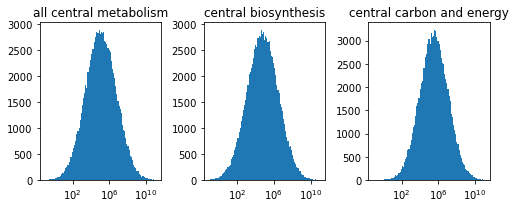

In [5]:
# Estimate ranges on kcat/KM by MC sampling kcat and KM.
fig, axs = plt.subplots(ncols=3, figsize=(7, 3))

for i, (gid, gdf) in enumerate(kin_ranges_df.groupby('label')):
    plt.sca(axs[i])
    
    reindexed = gdf.set_index('param')
    kcat_vals = reindexed.loc['kcat (1/sec)']
    KM_vals = reindexed.loc['KM (µM)']
    kcats = np.random.lognormal(np.log(kcat_vals.gmean),
                                np.log(kcat_vals.gstd),
                                100000)
    KMs = np.random.lognormal(np.log(KM_vals.gmean),
                              np.log(KM_vals.gstd),
                              100000)
    effs = kcats/(KMs*1e-6)

    gmean_eff = gmean(effs)
    gstd_eff = gstd(effs)
    print(gid)
    print('kcat/KM: {0:.2g} +/- {1:.2f} fold'.format(
        gmean_eff, gstd_eff))

    plt.xscale('log')
    plt.hist(effs, bins=np.logspace(-1, 11, 100))
    plt.title(gid)

plt.tight_layout()
plt.show()


    


In [6]:
davidi_kin_df = pd.read_excel('../data/enzymes/Davidi2016_kinetics.xlsx')
subunit_mw = davidi_kin_df['MW of subunit (KDa)']
prot_per_complex = davidi_kin_df['polypeptides per complex']
active_sites_per_complex = davidi_kin_df['catalytic sites per complex']
sites_per_polyp = active_sites_per_complex / prot_per_complex 

davidi_kin_df['active_sites_per_polypeptide'] = sites_per_polyp
davidi_kin_df['MW_per_active_site'] = subunit_mw/sites_per_polyp
davidi_kin_df['kcat_per_MW'] = (davidi_kin_df['kcat per active site [1/s]'] / 
                                davidi_kin_df['MW_per_active_site'])

davidi_kin_df.head()

,reaction (model name),bnumber,gene name,EC,kcat per active site [1/s],MW of subunit (KDa),polypeptides per complex,catalytic sites per complex,reference,reaction string (KEGG compound IDs),active_sites_per_polypeptide,MW_per_active_site,kcat_per_MW
0,3OAR140,b1093,fabG,1.1.1.100,0.59,25.56,4,4,PMID:6756317,C00002 + C00618 <=> C00008 + C14899,1.000000,25.56,0.023083
1,ACGS,b2818,argA,2.3.1.1,654.00,49.19,6,1,PMID:18801197,C00024 + C00025 <=> C00010 + C00624,0.166667,295.14,2.215898
2,ACODA,b3957,argE,3.5.99.6,1800.00,42.35,2,2,PMID:16201833,C01352 + C16218 <=> C00016 + C00412,1.000000,42.35,42.502952
3,ADSK,b2750,cysC,2.7.1.25,50.00,22.32,2,2,PMID:2549047,C00002 + C00224 <=> C00008 + C00053,1.000000,22.32,2.240143
4,ADSL2r,b1131,purB,2.7.1.23,11.00,51.54,4,4,PMID:15855156,C04823 <=> C00122 + C04677,1.000000,51.54,0.213426


MW active site: 46.2782 +/- 1.7358
kat per MW active site: 0.2571 +/- 13.3267


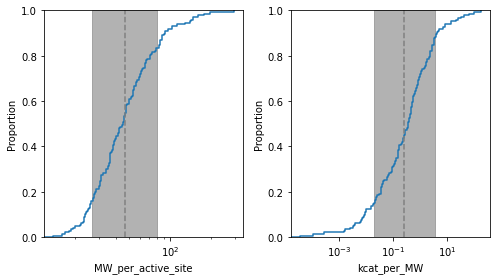

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(7,4))

plt.sca(axs[0])
plt.xscale('log')

sns.ecdfplot(data=davidi_kin_df, x='MW_per_active_site')
gmean_MW_per = gmean(davidi_kin_df['MW_per_active_site'])
gstd_MW_per = gstd(davidi_kin_df['MW_per_active_site'])
print('MW active site: {0:.4f} +/- {1:.4f}'.format(
    gmean_MW_per, gstd_MW_per))
plt.axvline(gmean_MW_per, color='grey', ls='--')
plt.axvspan(gmean_MW_per/gstd_MW_per, gmean_MW_per*gstd_MW_per, color='grey', alpha=0.6)

plt.sca(axs[1])
plt.xscale('log')
sns.ecdfplot(data=davidi_kin_df, x='kcat_per_MW')
gmean_kcat_per = gmean(davidi_kin_df['kcat_per_MW'])
gstd_kcat_per = gstd(davidi_kin_df['kcat_per_MW'])
print('kat per MW active site: {0:.4f} +/- {1:.4f}'.format(
    gmean_kcat_per, gstd_kcat_per))
plt.axvline(gmean_kcat_per, color='grey', ls='--')
plt.axvspan(gmean_kcat_per/gstd_kcat_per, gmean_kcat_per*gstd_kcat_per, color='grey', alpha=0.6)

plt.tight_layout()
plt.show()